# K210从训练到部署实战

## 0. 导入必要的库

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from  torchvision import utils
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

# 若检测到有GPU则使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/miniconda3/envs/pt12/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 参数设置

In [2]:
# 超参数设置
epochs = 20
batch_size_train = 64
batch_size_test = 64
lr = 0.01
momentum = 0.5

# 训练配置
num_workers = 12
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

## 2. 准备数据集

In [3]:
train_dataloader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.Resize(224),
                      transforms.ToTensor(),
                  ])),
    batch_size=batch_size_train, shuffle=True, num_workers=num_workers
)
test_dataloader = DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                  transform=transforms.Compose([
                      transforms.Resize(224),
                      transforms.ToTensor(),
                  ])),
    batch_size=batch_size_test, shuffle=True, num_workers=num_workers
)

### 2.1 数据集可视化

torch.Size([64])
torch.Size([64, 1, 224, 224])


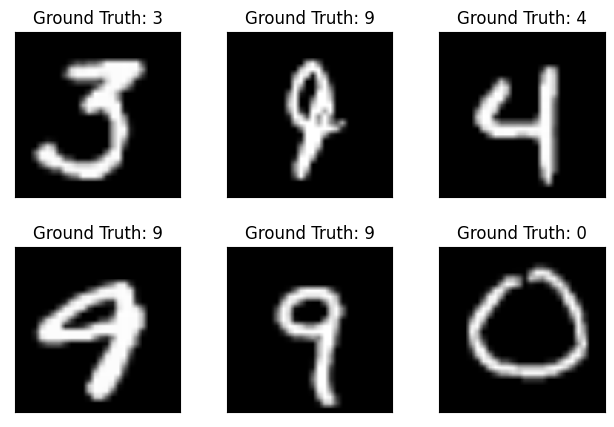

In [4]:
examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets.shape)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    #utils.save_image(example_data[i][0], str(i)+'.jpg', normalize=True)
plt.show()

## 3. 构建AlexNet网络

根据AlexNet原文来构建网络，如下图所示：

![AlexNet架构](https://imgconvert.csdnimg.cn/aHR0cHM6Ly9zczAuYmRzdGF0aWMuY29tLzcwY0Z2SFNoX1ExWW54R2twb1dLMUhGNmhoeS9pdC91PTE1NTQ3NzYzOTUsMzU0MDU4MzUwOSZmbT0yNiZncD0wLmpwZw?x-oss-process=image/format,png)

受到K210内存的限制，以下代码减少了参数量

In [5]:
'''
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1568,128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128,32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32,10)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,1568)
        x = self.classifier(x)
        return x

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        
        def nin_block(in_channels, out_channels, kernel_size, strides, padding):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
                nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=1), 
                nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True))
        
        self.features = nn.Sequential(
            nin_block(1, 32, kernel_size=3, strides=2, padding=1),
            nn.MaxPool2d(2),
            nin_block(32, 64, kernel_size=3, strides=2, padding=1),
            nn.MaxPool2d(2),
            nin_block(64, 128, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(2),
            # 标签类别数是10
            nin_block(128, 10, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            # 将四维的输出转成二维的输出，其形状为(批量大小,10)
            nn.Flatten())
    def forward(self,x):
        x = self.features(x)
        return x

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        
        def conv_dw(in_channels, out_channels, kernel_size, strides, padding):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, strides, padding, groups=in_channels),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True))
        
        self.features = nn.Sequential(
            conv_dw(1,16,kernel_size=3,strides=2,padding=1),
            nn.MaxPool2d(2),
            conv_dw(16,32,kernel_size=3,strides=2,padding=1),
            nn.MaxPool2d(2),
            conv_dw(32,64,kernel_size=3,strides=1,padding=1),
            conv_dw(64,64,kernel_size=3,strides=1,padding=1),
            conv_dw(64,32,kernel_size=3,strides=1,padding=1),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1568,128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128,32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32,10)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,1568)
        x = self.classifier(x)
        return x
'''

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        
        def conv_dw(in_channels, out_channels, kernel_size, strides, padding):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, strides, padding, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels), nn.ReLU6(inplace=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), 
                nn.BatchNorm2d(out_channels), nn.ReLU6(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False), 
                nn.BatchNorm2d(out_channels), nn.ReLU6(inplace=True))
        
        self.features = nn.Sequential(
            conv_dw(1,32,kernel_size=3,strides=2,padding=1),
            nn.MaxPool2d(2),
            conv_dw(32,64,kernel_size=3,strides=2,padding=1),
            nn.MaxPool2d(2),
            conv_dw(64,128,kernel_size=3,strides=1,padding=1),
            nn.MaxPool2d(2),
            conv_dw(128,10,kernel_size=3,strides=1,padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )
        
    def forward(self,x):
        x = self.features(x)
        return x


## 4. 定义优化器和损失函数

In [6]:
net = AlexNet().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

## 5. 训练评估及可视化

### 5.1 精度评估

In [7]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) >= 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

### 5.2 训练部分

In [8]:
#@save
def train(net, train_iter, test_iter, num_epochs, optimizer, loss, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    num_batches = len(train_iter)
    best_acc = 0
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        if test_acc > best_acc:
            torch.save(net,'best.pt')
            best_acc = test_acc
            print(f'best model saved, loss {train_l:.3f}, train acc {train_acc:.3f}, '
                  f'test acc {test_acc:.3f}')
        print(f'epoch {epoch}: loss {train_l:.3f}, train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}')
    torch.save(net,'last.pt')

### 5.3 开始训练

In [9]:
train(net, train_dataloader, test_dataloader, epochs, optimizer, loss, device)

training on cuda
best model saved, loss 1.517, train acc 0.741, test acc 0.891
epoch 0: loss 1.517, train acc 0.741, test acc 0.891
best model saved, loss 0.743, train acc 0.920, test acc 0.949
epoch 1: loss 0.743, train acc 0.920, test acc 0.949
best model saved, loss 0.513, train acc 0.946, test acc 0.960
epoch 2: loss 0.513, train acc 0.946, test acc 0.960
best model saved, loss 0.421, train acc 0.958, test acc 0.965
epoch 3: loss 0.421, train acc 0.958, test acc 0.965
best model saved, loss 0.368, train acc 0.964, test acc 0.968
epoch 4: loss 0.368, train acc 0.964, test acc 0.968
best model saved, loss 0.335, train acc 0.968, test acc 0.972
epoch 5: loss 0.335, train acc 0.968, test acc 0.972
best model saved, loss 0.309, train acc 0.971, test acc 0.975
epoch 6: loss 0.309, train acc 0.971, test acc 0.975
best model saved, loss 0.291, train acc 0.973, test acc 0.976
epoch 7: loss 0.291, train acc 0.973, test acc 0.976
epoch 8: loss 0.276, train acc 0.975, test acc 0.975
epoch 9: l

## 6. PyTorch模型导出为ONNX格式

In [10]:
model = torch.load('./result/MobileNetNINV3/best.pt').to(device)
model.eval()
# 复杂度计算
from thop import profile
input_data = torch.randn(1, 1, 224, 224, device=device)
macs, params = profile(model, inputs=(input_data,))
print('FLOPs = ' + str((2*macs)/1024**3) + 'G')
print('Params = ' + str(params/1024**2) + 'M')
# 导出为ONNX
# set the model to inference mode 
model.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(1, 1, 224, 224, requires_grad=True, device=device)  

# Export the model   
torch.onnx.export(model,         # model being run 
     dummy_input,       # model input (or a tuple for multiple inputs) 
     "./result/MobileNetNINV3/MobileNetNINV3.onnx",       # where to save the model  
     export_params=True,  # store the trained parameter weights inside the model file 
     opset_version=10,    # the ONNX version to export the model to 
     do_constant_folding=True,  # whether to execute constant folding for optimization 
     input_names = ['modelInput'],   # the model's input names 
     output_names = ['modelOutput'], # the model's output names 
     dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                            'modelOutput' : {0 : 'batch_size'}}) 
print(" ") 
print('Model has been converted to ONNX')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
FLOPs = 0.051221802830696106G
Params = 0.034873008728027344M
 
Model has been converted to ONNX


### 6.1 ONNX模型推理验证

torch.Size([64])
torch.Size([64, 1, 224, 224])


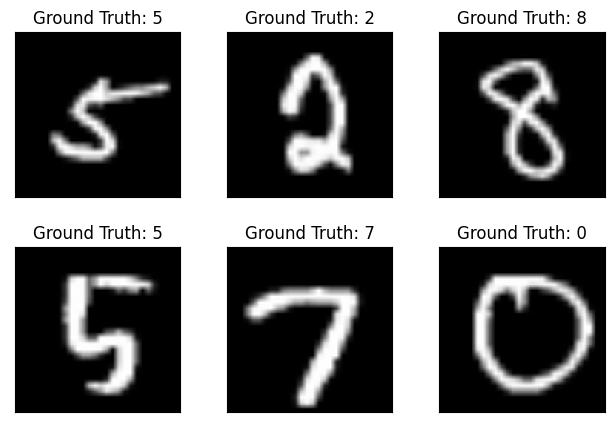

In [11]:
## 自定义数据集
path = '../data/MNIST_jpg/test/'
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
])
test_data = datasets.ImageFolder(root=path, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=12)

examples = enumerate(test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets.shape)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    #utils.save_image(example_data[i][0], str(i)+'.jpg', normalize=True)
plt.show()

In [12]:
## 模型结构验证
import onnx
onnx_model = onnx.load("./result/MobileNetNINV3/MobileNetNINV3.onnx")
print(onnx.checker.check_model(onnx_model))

None


In [13]:
## 随机张量验证
import onnxruntime

ort_session = onnxruntime.InferenceSession("./result/MobileNetNINV3/MobileNetNINV3.onnx")
    
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

input_data = torch.randn(1, 1, 224, 224)
ort_input = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
ort_out = ort_session.run(None, ort_input)
torch_out = model(input_data.to(device))

print(ort_out)
print(to_numpy(torch_out))
print(np.testing.assert_allclose(to_numpy(torch_out), ort_out[0], rtol=1e-03, atol=1e-05))


[array([[2.9933453 , 0.02157369, 2.0431364 , 0.38252744, 0.6564236 ,
        0.06087637, 1.2375767 , 0.28338006, 5.4265604 , 0.8812874 ]],
      dtype=float32)]
[[2.98755    0.02150728 2.042802   0.38328856 0.65662956 0.06116159
  1.2438031  0.28399426 5.42626    0.8798849 ]]


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 7 / 10 (70%)
Max absolute difference: 0.00622642
Max relative difference: 0.00503114
 x: array([[2.98755 , 0.021507, 2.042802, 0.383289, 0.65663 , 0.061162,
        1.243803, 0.283994, 5.42626 , 0.879885]], dtype=float32)
 y: array([[2.993345, 0.021574, 2.043136, 0.382527, 0.656424, 0.060876,
        1.237577, 0.28338 , 5.42656 , 0.881287]], dtype=float32)

tensor(5)
[array([[0.6377915 , 0.71908337, 1.0222324 , 0.79628515, 0.897536  ,
        5.1704874 , 1.0947496 , 0.9172023 , 0.7520262 , 0.9622062 ]],
      dtype=float32)]
[[0.63919437 0.71478754 1.0176926  0.79511476 0.9044933  5.1733747
  1.0955784  0.9127702  0.75432515 0.96393913]]


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 8 / 10 (80%)
Max absolute difference: 0.00695729
Max relative difference: 0.00775155
 x: array([[0.639194, 0.714788, 1.017693, 0.795115, 0.904493, 5.173375,
        1.095578, 0.91277 , 0.754325, 0.963939]], dtype=float32)
 y: array([[0.637792, 0.719083, 1.022232, 0.796285, 0.897536, 5.170487,
        1.09475 , 0.917202, 0.752026, 0.962206]], dtype=float32)

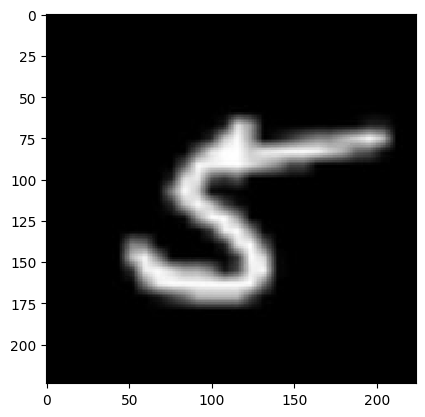

In [14]:
## 测试集图像验证
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
input_data = example_data[0][0].view(-1,1,224,224)
ort_input = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
ort_out = ort_session.run(None, ort_input)
torch_out = model(input_data.to(device))

print(example_targets[0])
print(ort_out)
print(to_numpy(torch_out))
print(np.testing.assert_allclose(to_numpy(torch_out), ort_out[0], rtol=1e-03, atol=1e-05))

In [15]:
## 测试集精度验证
# 正确预测的数量，总预测的数量
metric = Accumulator(2)
for X, y in test_dataloader:
    ort_input = {ort_session.get_inputs()[0].name: to_numpy(X)}
    ort_out = ort_session.run(None, ort_input)
    prediction = torch.Tensor(ort_out).view(-1,10)
    metric.add(accuracy(prediction, y), y.numel())
test_acc = metric[0] / metric[1]
print(f'test acc {test_acc:.3f}')

metric = Accumulator(2)
model.eval()
for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    prediction = model(X)
    metric.add(accuracy(prediction, y), y.numel())
test_acc = metric[0] / metric[1]
print(f'test acc {test_acc:.3f}')

/tmp/ipykernel_112075/3661651715.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/utils/tensor_new.cpp:201.)
  prediction = torch.Tensor(ort_out).view(-1,10)


test acc 0.982
test acc 0.982


## 7. ONNX模型导出为KModel格式

### 7.1 ONNX模型直接转换为KModel格式

In [16]:
import nncase
import onnxsim
import os

def parse_model_input_output(model_file):
    onnx_model = onnx.load(model_file)
    input_all = [node.name for node in onnx_model.graph.input]
    input_initializer = [node.name for node in onnx_model.graph.initializer]
    input_names = list(set(input_all) - set(input_initializer))
    input_tensors = [node for node in onnx_model.graph.input if node.name in input_names]

    # input
    inputs = []
    for _, e in enumerate(input_tensors):
        onnx_type = e.type.tensor_type
        input_dict = {}
        input_dict['name'] = e.name
        input_dict['dtype'] = onnx.mapping.TENSOR_TYPE_TO_NP_TYPE[onnx_type.elem_type]
        input_dict['shape'] = [(i.dim_value if i.dim_value != 0 else d) for i, d in zip(
            onnx_type.shape.dim, [1, 3, 224, 224])]
        inputs.append(input_dict)

    return onnx_model, inputs

def onnx_simplify(model_file):
    onnx_model, inputs = parse_model_input_output(model_file)
    onnx_model = onnx.shape_inference.infer_shapes(onnx_model)
    input_shapes = {}
    for input in inputs:
        input_shapes[input['name']] = input['shape']

    onnx_model, check = onnxsim.simplify(onnx_model, overwrite_input_shapes=input_shapes)
    assert check, "Simplified ONNX model could not be validated"

    model_file = os.path.join(os.path.dirname(model_file), 'MobileNetNINV3_simplified.onnx')
    onnx.save_model(onnx_model, model_file)
    return model_file

def read_model_file(model_file):
    with open(model_file, 'rb') as f:
        model_content = f.read()
    return model_content

# onnx simplify
model_file = onnx_simplify("./result/MobileNetNINV3/MobileNetNINV3.onnx")

# compile_options
compile_options = nncase.CompileOptions()
compile_options.target = 'k210'
compile_options.dump_ir = True
compile_options.dump_asm = True
compile_options.dump_dir = 'tmp'

# compiler
compiler = nncase.Compiler(compile_options)

# import_options
import_options = nncase.ImportOptions()

# import
model_content = read_model_file(model_file)
compiler.import_onnx(model_content, import_options)

# compile
compiler.compile()

# kmodel
kmodel = compiler.gencode_tobytes()
name = os.path.basename(model_file).split(".")[0]
with open(f'{name}.kmodel', 'wb') as f:
    f.write(kmodel)

1. Import graph...
2. Optimize target independent...
3. Optimize target dependent...
5. Optimize target dependent after quantization...
6. Optimize modules...
7.1. Merge module regions...
7.2. Optimize buffer fusion...
7.3. Optimize target dependent after buffer fusion...
8. Generate code...
WARN: Cannot find a decompiler for section .rdata
WARN: Cannot find a decompiler for section .text

SUMMARY
INPUTS
0	modelInput	f32[1,1,224,224]
OUTPUTS
0	modelOutput	f32[1,10]

MEMORY USAGES
.input	 196.00 KB	(200704 B)
.output	  40.00 B	(40 B)
.data	   3.11 MB	(3261440 B)
MODEL	 143.38 KB	(146816 B)
TOTAL	   3.44 MB	(3609000 B)


## 7.2 ONNX模型转换成TFlite格式再转换成KModel格式

In [17]:
from onnx_tf.backend import prepare
import tensorflow as tf

TF_PATH = "./result/MobileNetNINV3/MobileNetNINV3.pb" # where the representation of tensorflow model will be stored
ONNX_PATH = "./result/MobileNetNINV3/MobileNetNINV3_simplified.onnx" # path to my existing ONNX model
onnx_model = onnx.load(ONNX_PATH)  # load onnx model
tf_rep = prepare(onnx_model)  # creating TensorflowRep object
tf_rep.export_graph(TF_PATH)

TFLITE_PATH = "./result/MobileNetNINV3/MobileNetNINV32.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
## 启用量化配置
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_model = converter.convert()
with open(TFLITE_PATH, 'wb') as f:
    f.write(tf_lite_model)

/opt/miniconda3/envs/pt12/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2023-04-11 15:39:46.634164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 15:39:46.634499: W tensorflow/strea

INFO:tensorflow:Assets written to: ./result/MobileNetNINV3/MobileNetNINV3.pb/assets


INFO:tensorflow:Assets written to: ./result/MobileNetNINV3/MobileNetNINV3.pb/assets
2023-04-11 15:39:50.070104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2023-04-11 15:39:50.070130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2023-04-11 15:39:50.070136: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2023-04-11 15:39:50.070959: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./result/MobileNetNINV3/MobileNetNINV3.pb
2023-04-11 15:39:50.073087: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-04-11 15:39:50.073106: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: ./result/MobileNetNINV3/MobileNetNINV3.pb
2023-04-11 15:39:50.079689: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2023-04-11 1

Estimated count of arithmetic ops: 48.399 M  ops, equivalently 24.200 M  MACs


In [18]:
from tinynn.converter import TFLiteConverter

model = torch.load('./result/MobileNetNINV3/best.pt')
model.eval()

dummy_input = torch.rand((1, 1, 224, 224))

output_path = os.path.join('./result/MobileNetNINV3/MobileNetNINV3.tflite')

# When converting quantized models, please ensure the quantization backend is set.
#torch.backends.quantized.engine = 'qnnpack'

# The code section below is used to convert the model to the TFLite format
# If you want perform dynamic quantization on the float models,
# you may refer to `dynamic.py`, which is in the same folder.
# As for static quantization (e.g. quantization-aware training and post-training quantization),
# please refer to the code examples in the `examples/quantization` folder.
converter = TFLiteConverter(model, dummy_input, output_path)
converter.convert()

INFO:tinynn.converter.base:Generated model saved to ./result/MobileNetNINV3/MobileNetNINV3.tflite


### 7.3 Simplified ONNX精度验证

In [19]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("./result/MobileNetNINV3/MobileNetNINV3_simplified.onnx")
    
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## 测试集精度验证
# 正确预测的数量，总预测的数量
metric = Accumulator(2)
for X, y in test_dataloader:
    for i in range(y.shape[0]):
        input_data = X[i].view(-1,1,224,224)
        ort_input = {ort_session.get_inputs()[0].name: to_numpy(input_data)}
        ort_out = ort_session.run(None, ort_input)
        prediction = torch.Tensor(ort_out).view(-1,10)
        ground_truth = y[i].view(-1)
        metric.add(accuracy(prediction, ground_truth), ground_truth.numel())
test_acc = metric[0] / metric[1]
print(f'test acc {test_acc:.3f}')

test acc 0.982


### 7.4 TFlite精度验证

In [20]:
interpreter = tf.lite.Interpreter(model_path='./result/MobileNetNINV3/MobileNetNINV3.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(str(input_details))
output_details = interpreter.get_output_details()
print(str(output_details))

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## 测试集精度验证
# 正确预测的数量，总预测的数量
metric = Accumulator(2)
for X, y in test_dataloader:
    for i in range(y.shape[0]):
        input_data = X[i].view(-1,1,224,224)
        ## NCHW转NHWC 
        input_data = input_data.permute(0,2,3,1)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        output_data = torch.from_numpy(output_data)
        ground_truth = y[i].view(-1)
        metric.add(accuracy(output_data, ground_truth), ground_truth.numel())
    print(metric[0] / metric[1])
test_acc = metric[0] / metric[1]
print(f'test acc {test_acc:.3f}')

[{'name': 'x.1', 'index': 44, 'shape': array([  1, 224, 224,   1], dtype=int32), 'shape_signature': array([  1, 224, 224,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': '236', 'index': 4, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
0.984375
0.9765625
0.984375
0.984375
0.98125
0.9817708333333334
0.9821428571428571
0.98046875
0.9791666666666666
0.9765625
0.9758522727272727
0.9752604166666666
0.9747596153846154
0.9732142857142857
0.9729166666666667
0.9716796875
0.9724264705882353
0.9739583333333334
0.9745065789473685
0.975
0.974702380

### 7.1 KModel精度验证